importing all the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



In [4]:
# Reading the data
df = pd.read_csv("/content/spam.csv",encoding='latin-1')
df.head()



,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


As we can see that the dataset contains three unnamed columns with null values. So we drop those columns and rename the columns v1 and v2 to label and Text, respectively. Since the target variable is in string form, we will encode it numerically using pandas function .map().



In [5]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()



,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


Let’s visualize the distribution of Ham and Spam data.

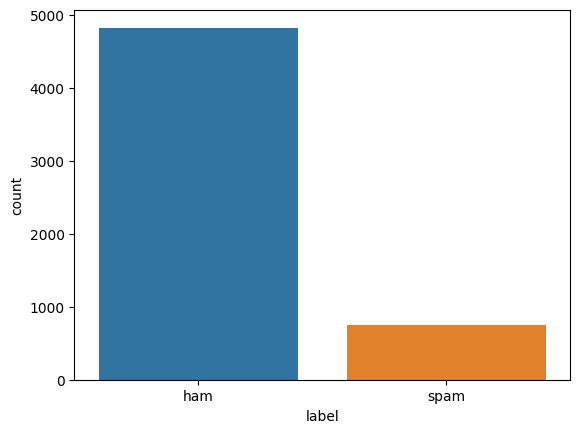

In [6]:
sns.countplot(x=df['label'])
plt.show()



The ham data is comparatively higher than spam data, it’s natural. Since we are going to use embeddings in our deep learning model, we need not balance the data. Now, let’s find the average number of words in all the sentences in SMS data.

In [7]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)



15


Now, let’s find the total number of unique words in the corpus

In [9]:
s = set()
for sent in df['Text']:
    for word in sent.split():
        s.add(word)
total_words_length = len(s)
print(total_words_length)


15585


Now,  splitting the data into training and testing parts using train_test_split() function.



In [10]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
	new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape



((4457,), (4457,), (1115,), (1115,))

Building the models
First, we will build a baseline model and then we’ll try to beat the performance of the baseline model using deep learning models (embeddings, LSTM, etc)

Here, we will choose MultinomialNB(), which performs well for text classification when the features are discrete like word counts of the words or tf-idf vectors. The tf-idf is a measure that tells how important or relevant a word is the document.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)



MultinomialNB()

In [12]:
nb_accuracy =accuracy_score(y_test,baseline_model.predict(X_test_vec))
print(nb_accuracy)
print(classification_report(y_test,baseline_model.predict(X_test_vec)))

0.9623318385650225
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



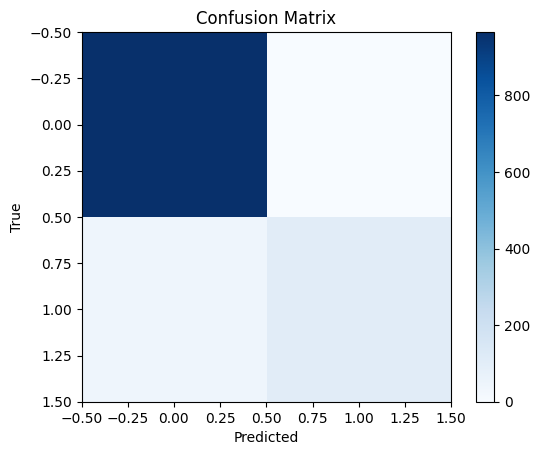

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

y_pred = baseline_model.predict(X_test_vec)
cm = confusion_matrix(y_test, y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Model 1: Creating custom Text vectorization and embedding layers:

Text vectorization is the process of converting text into a numerical representation. Example: Bag of words frequency, Binary Term frequency, etc.;

A word embedding is a learned representation of text in which words with related meanings have similar representations. Each word is assigned to a single vector, and the vector values are learned like that of a neural network.

Now, we’ll create a custom text vectorization layer using TensorFlow.



In [15]:
from tensorflow.keras.layers import TextVectorization

MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len

text_vec = TextVectorization(
	max_tokens=MAXTOKENS,
	standardize='lower_and_strip_punctuation',
	output_mode='int',
	output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)



MAXTOKENS is the maximum size of the vocabulary which was found earlier
OUTPUTLEN is the length to which the sentences should be padded irrespective of the sentence length.


In [16]:
sample_sentence ='this is message'
text_vec([sample_sentence])


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 41,  10, 148,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

Now let’s create an embedding layer




In [17]:
embedding_layer = layers.Embedding(
	input_dim=MAXTOKENS,
	output_dim=128,
	embeddings_initializer='uniform',
	input_length=OUTPUTLEN
)



input_dim is the size of vocabulary

output_dim is the dimension of the embedding layer i.e, the size of the vector in which the words will be embedded

input_length is the length of input sequences


Now, let’s build and compile model 1 using the Tensorflow Functional API



In [18]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
	label_smoothing=0.5), metrics=['accuracy'])



summary of the model:

In [19]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128  

Training the model-1

In [20]:
history_1 = model_1.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test),validation_steps=int(0.2*len(X_test)))

Epoch 1/5
140/140 [==============================] - 6s 33ms/step - loss: 0.6091 - accuracy: 0.9040 - val_loss: 0.5768 - val_accuracy: 0.9713
Epoch 2/5
140/140 [==============================] - 5s 35ms/step - loss: 0.5703 - accuracy: 0.9868 - val_loss: 0.5732 - val_accuracy: 0.9794
Epoch 3/5
140/140 [==============================] - 4s 29ms/step - loss: 0.5658 - accuracy: 0.9946 - val_loss: 0.5728 - val_accuracy: 0.9821
Epoch 4/5
140/140 [==============================] - 4s 31ms/step - loss: 0.5641 - accuracy: 0.9987 - val_loss: 0.5722 - val_accuracy: 0.9821
Epoch 5/5
140/140 [==============================] - 6s 44ms/step - loss: 0.5633 - accuracy: 0.9991 - val_loss: 0.5724 - val_accuracy: 0.9794


Plotting the history of model-1



<Axes: >

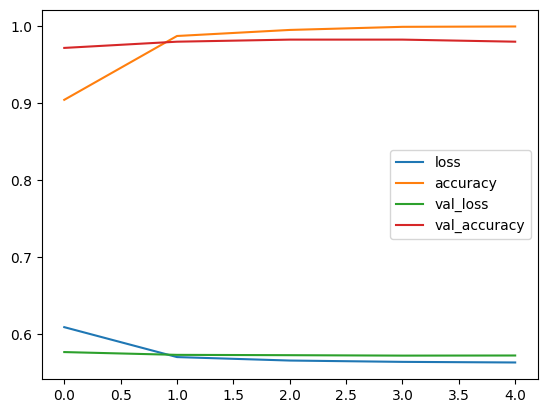

In [21]:
pd.DataFrame(history_1.history).plot()

Let’s create helper functions for compiling, fitting, and evaluating the model performance.

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
	'''
	simply compile the model with adam optimzer
	'''
	model.compile(optimizer=keras.optimizers.Adam(),
				loss=keras.losses.BinaryCrossentropy(),
				metrics=['accuracy'])

def fit_model(model, epochs, X_train=X_train, y_train=y_train,
			X_test=X_test, y_test=y_test):
	'''
	fit the model with given epochs, train
	and test data
	'''
	history = model.fit(X_train,
						y_train,
						epochs=epochs,
						validation_data=(X_test, y_test),
						validation_steps=int(0.2*len(X_test)))
	return history

def evaluate_model(model, X, y):
	'''
	evaluate the model and returns accuracy,
	precision, recall and f1-score
	'''
	y_preds = np.round(model.predict(X))
	accuracy = accuracy_score(y, y_preds)
	precision = precision_score(y, y_preds)
	recall = recall_score(y, y_preds)
	f1 = f1_score(y, y_preds)

	model_results_dict = {'accuracy': accuracy,
						'precision': precision,
						'recall': recall,
						'f1-score': f1}

	return model_results_dict



Model -2 Bidirectional LSTM

A bidirectional LSTM (Long short-term memory) is made up of two LSTMs, one accepting input in one direction and the other in the other. BiLSTMs effectively improve the network’s accessible information, boosting the context for the algorithm (e.g. knowing what words immediately follow and precede a word in a sentence).

Building and compiling the model-2

In [23]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
	64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2) # compile the model
history_2 = fit_model(model_2, epochs=5) # fit the model



Epoch 1/5
140/140 [==============================] - 27s 110ms/step - loss: 0.0578 - accuracy: 0.9834 - val_loss: 0.1201 - val_accuracy: 0.9731
Epoch 2/5
140/140 [==============================] - 29s 208ms/step - loss: 0.0035 - accuracy: 0.9996 - val_loss: 0.1069 - val_accuracy: 0.9848
Epoch 3/5
140/140 [==============================] - 15s 106ms/step - loss: 2.6232e-04 - accuracy: 1.0000 - val_loss: 0.1228 - val_accuracy: 0.9821
Epoch 4/5
140/140 [==============================] - 15s 106ms/step - loss: 3.1538e-05 - accuracy: 1.0000 - val_loss: 0.1320 - val_accuracy: 0.9821
Epoch 5/5
140/140 [==============================] - 13s 92ms/step - loss: 1.9219e-05 - accuracy: 1.0000 - val_loss: 0.1386 - val_accuracy: 0.9821


In [24]:
compile_model(model_2)
history_2 = fit_model(model_2,epochs=5)


Epoch 1/5
140/140 [==============================] - 32s 139ms/step - loss: 1.2179e-06 - accuracy: 1.0000 - val_loss: 0.2073 - val_accuracy: 0.9821
Epoch 2/5
140/140 [==============================] - 22s 155ms/step - loss: 7.3906e-08 - accuracy: 1.0000 - val_loss: 0.2167 - val_accuracy: 0.9821
Epoch 3/5
140/140 [==============================] - 18s 126ms/step - loss: 3.6061e-08 - accuracy: 1.0000 - val_loss: 0.2246 - val_accuracy: 0.9821
Epoch 4/5
140/140 [==============================] - 29s 205ms/step - loss: 2.1776e-08 - accuracy: 1.0000 - val_loss: 0.2353 - val_accuracy: 0.9821
Epoch 5/5
140/140 [==============================] - 24s 173ms/step - loss: 1.4119e-08 - accuracy: 1.0000 - val_loss: 0.2389 - val_accuracy: 0.9821


Model -3 Transfer Learning with USE Encoder

Transfer Learning

Transfer learning is a machine learning approach in which a model generated for one job is utilized as the foundation for a model on a different task.

USE Layer (Universal Sentence Encoder)

The Universal Sentence Encoder converts text into high-dimensional vectors that may be used for text categorization, semantic similarity, and other natural language applications.

The USE can be downloaded from tensorflow_hub and can be used as a layer using .kerasLayer() function.

In [26]:
import tensorflow_hub as hub

# model with Sequential api
model_3 = keras.Sequential()

# universal-sentence-encoder layer
# directly from tfhub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
						trainable=False,
						input_shape=[],
						dtype=tf.string,
						name='USE')
model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation=keras.activations.relu))
model_3.add(layers.Dense(1, activation=keras.activations.sigmoid))

compile_model(model_3)

history_3 = fit_model(model_3, epochs=5)



Epoch 1/5
140/140 [==============================] - 7s 23ms/step - loss: 0.2962 - accuracy: 0.9154 - val_loss: 0.1138 - val_accuracy: 0.9731
Epoch 2/5
140/140 [==============================] - 4s 31ms/step - loss: 0.0813 - accuracy: 0.9796 - val_loss: 0.0719 - val_accuracy: 0.9767
Epoch 3/5
140/140 [==============================] - 5s 38ms/step - loss: 0.0569 - accuracy: 0.9814 - val_loss: 0.0595 - val_accuracy: 0.9803
Epoch 4/5
140/140 [==============================] - 3s 21ms/step - loss: 0.0491 - accuracy: 0.9850 - val_loss: 0.0544 - val_accuracy: 0.9830
Epoch 5/5
140/140 [==============================] - 4s 28ms/step - loss: 0.0404 - accuracy: 0.9877 - val_loss: 0.0514 - val_accuracy: 0.9857


In [27]:
compile_model(model_3)
history_3 = fit_model(model_3,epochs=5)

Epoch 1/5
140/140 [==============================] - 5s 29ms/step - loss: 0.0345 - accuracy: 0.9892 - val_loss: 0.0502 - val_accuracy: 0.9848
Epoch 2/5
140/140 [==============================] - 3s 24ms/step - loss: 0.0353 - accuracy: 0.9865 - val_loss: 0.0512 - val_accuracy: 0.9830
Epoch 3/5
140/140 [==============================] - 4s 28ms/step - loss: 0.0298 - accuracy: 0.9910 - val_loss: 0.0522 - val_accuracy: 0.9830
Epoch 4/5
140/140 [==============================] - 3s 21ms/step - loss: 0.0270 - accuracy: 0.9915 - val_loss: 0.0566 - val_accuracy: 0.9821
Epoch 5/5
140/140 [==============================] - 3s 20ms/step - loss: 0.0253 - accuracy: 0.9924 - val_loss: 0.0530 - val_accuracy: 0.9830


Analyzing our Model Performance

We will use the helper function which we created earlier to evaluate model performance.

In [28]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
model_3_results = evaluate_model(model_3, X_test, y_test)

total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
							'Custom-Vec-Embedding Model':model_1_results,
							'Bidirectional-LSTM Model':model_2_results,
							'USE-Transfer learning Model':model_3_results}).transpose()

total_results



35/35 [==============================] - 1s 17ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.979372,0.984733,0.860000,0.918149
Bidirectional-LSTM Model,0.982063,0.971014,0.893333,0.930556
USE-Transfer learning Model,0.982960,0.964539,0.906667,0.934708


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(total_results, *['accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(total_results, *['precision'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(total_results, *['recall'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(total_results, *['f1-score'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(total_results, *['accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(total_results, *['precision'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(total_results, *['recall'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(total_results, *['f1-score'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 10 * figscale, 10 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(total_results, *[[['accuracy', 'precision'], ['precision', 'recall'], ['recall', 'f1-score']]], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(total_results, *['accuracy', 'precision', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(total_results, *['accuracy', 'count()', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(total_results, *['recall', 'precision', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(total_results, *['recall', 'count()', None], **{})
chart

Metrics

All four models deliver excellent results. (All of them have greater than 96 percent accuracy)
